# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)
# %matplotlib notebook
# import matplotlib
# # matplotlib.use('Agg')
# matplotlib.use('Agg')


Running date: June 05, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


In [10]:
print (matplotlib.rcParams['backend'])

agg


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

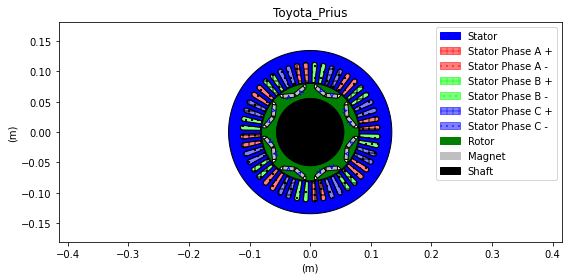

In [3]:
from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent

from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D
from pyleecan.definitions import DATA_DIR


# Load machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Toyota_Prius = load('D:\KDH\Toyota_Prius.json')
Toyota_Prius.plot()

## Simu 1 Simulation (No-load)

In [181]:
simu1 = Simu1(name="IPMSM_AGSF_spectrum_sym", machine=Toyota_Prius)
simu1.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0, N0=1500),
    Ir=None,
    Na_tot=252 * 8, #2016 
#     Nt_tot=(4 * 2) ** 4, #Time :4096
    Nt_tot=(4 * 2) * 16, #Time :128
)

simu1.elec = None

simu1.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu1.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)

simu1.mag.is_periodicity_a = True #?
simu1.mag.is_periodicity_t = True #?

simu1.force.is_periodicity_a = True # ?
simu1.force.is_periodicity_t = True # ?


simu1.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu1.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file


simu1.mag.nb_worker = 4
out_noload = simu1.run()
AGSF_noload = out_noload.force.AGSF


[18:10:08] Starting running simulation IPMSM_AGSF_spectrum_sym (machine=Toyota_Prius)
[18:10:08] Starting Magnetic module
[18:10:09] Solving time step 1 / 16 in FEMM
[18:10:09] Solving time step 5 / 16 in FEMM
[18:10:09] Solving time step 9 / 16 in FEMM
[18:10:10] Solving time step 13 / 16 in FEMM
[18:10:10] Solving time step 2 / 16 in FEMM
[18:10:11] Solving time step 6 / 16 in FEMM
[18:10:11] Solving time step 10 / 16 in FEMM
[18:10:11] Solving time step 14 / 16 in FEMM
[18:10:11] Solving time step 3 / 16 in FEMM
[18:10:12] Solving time step 7 / 16 in FEMM
[18:10:12] Solving time step 11 / 16 in FEMM
[18:10:12] Solving time step 15 / 16 in FEMM
[18:10:12] Solving time step 4 / 16 in FEMM
[18:10:13] Solving time step 8 / 16 in FEMM
[18:10:13] Solving time step 12 / 16 in FEMM
[18:10:13] Solving time step 16 / 16 in FEMM
[18:10:14] Starting Force module
[18:10:14] End of simulation IPMSM_AGSF_spectrum_sym


## Simu2 simulation (Load)


In [183]:
import math

simu2 = Simu1(name="IPMSM_AGSF_spectrum_load", machine=Toyota_Prius)

# I0, Phi0 설정
I0_rms = 250/math.sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp

# 해당 Id/Iq 계산
Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag

#정현파 전류의 정의
simu2.input = InputCurrent(
    OP=OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref, N0=1500),
    Ir=None,
    Na_tot=252 * 8, #2016
#     Nt_tot=(4 * 2 )** 4, #Time :4096
    Nt_tot=(4 * 2 )*16, #Time :128
)
# simu2.input.OP = OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref)
#     Nt_tot=50 * 8,  #400
#    Na_tot=2 ** 6, #Angle : 64
#    Nt_tot=120, 
simu2.elec = None

simu2.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu2.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)

# simu2.mag.is_periodicity_a = True #?
# simu2.mag.is_periodicity_t = True #?

# simu2.force.is_periodicity_a = True # ?
# simu2.force.is_periodicity_t = True # ?


simu2.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu2.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file


simu2.mag.nb_worker = 4
out_load = simu2.run()
AGSF_load = out_load.force.AGSF





[18:10:37] Starting running simulation IPMSM_AGSF_spectrum_load (machine=Toyota_Prius)
[18:10:37] Starting Magnetic module
[18:10:38] Solving time step 5 / 16 in FEMM
[18:10:38] Solving time step 1 / 16 in FEMM
[18:10:38] Solving time step 9 / 16 in FEMM
[18:10:39] Solving time step 13 / 16 in FEMM
[18:10:39] Solving time step 6 / 16 in FEMM
[18:10:40] Solving time step 2 / 16 in FEMM
[18:10:40] Solving time step 10 / 16 in FEMM
[18:10:40] Solving time step 14 / 16 in FEMM
[18:10:40] Solving time step 7 / 16 in FEMM
[18:10:41] Solving time step 11 / 16 in FEMM
[18:10:41] Solving time step 3 / 16 in FEMM
[18:10:41] Solving time step 15 / 16 in FEMM
[18:10:41] Solving time step 8 / 16 in FEMM
[18:10:42] Solving time step 4 / 16 in FEMM
[18:10:42] Solving time step 12 / 16 in FEMM
[18:10:42] Solving time step 16 / 16 in FEMM
[18:10:43] Starting Force module
[18:10:43] End of simulation IPMSM_AGSF_spectrum_load


In [184]:
out_load.mag.meshsolution.plot_contour(label="B", clim=[0,2])
out_noload.mag.meshsolution.plot_contour(label="B", clim=[0,2])

#group_names="Stator Core"
#,is_animated=True,is_show_fig=False,
        # save_path="D:\plot_mesh_stator.gif"

# Plot &  Data Check(Load) -3D Airgap Flux density (One rotation,Oneperiod, Smallestperiod)

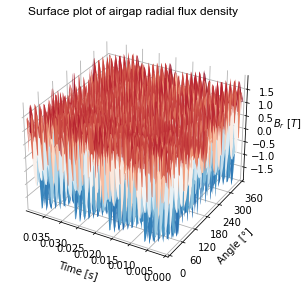

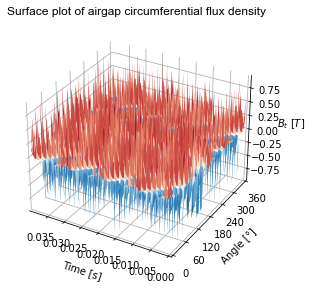

In [185]:
out_load.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False)

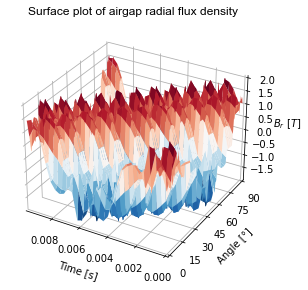

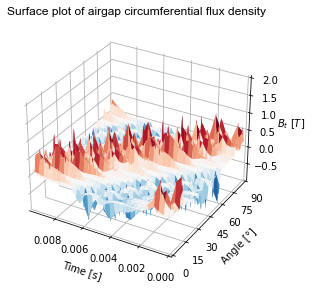

In [186]:
out_load.mag.B.plot_3D_Data("time[oneperiod]", "angle[oneperiod]{°}", is_2D_view=False,z_max=2)

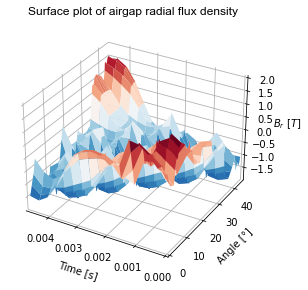

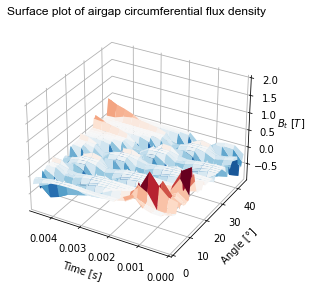

In [187]:
out_load.mag.B.plot_3D_Data("time[smallestperiod]", "angle[smallestperiod]{°}", is_2D_view=False, z_max=2)

## Data check(Load) 공간 자속밀도분포(공극) 

### Spatial Distribution

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

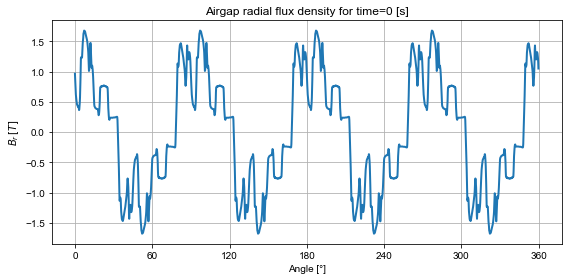

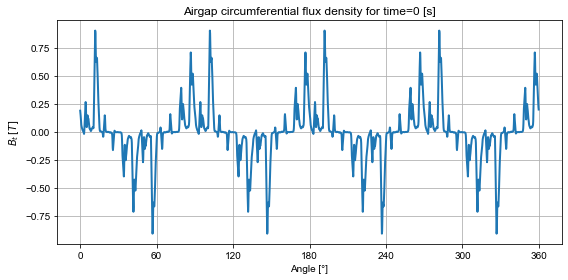

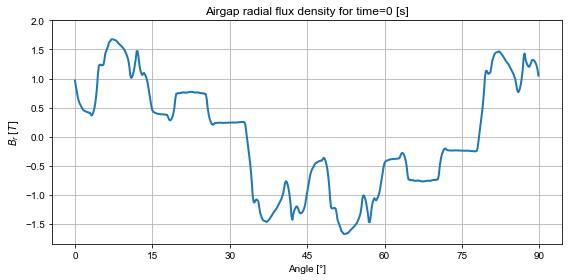

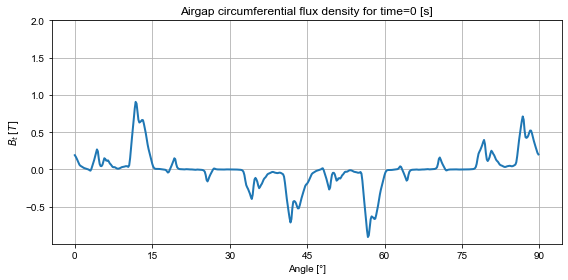

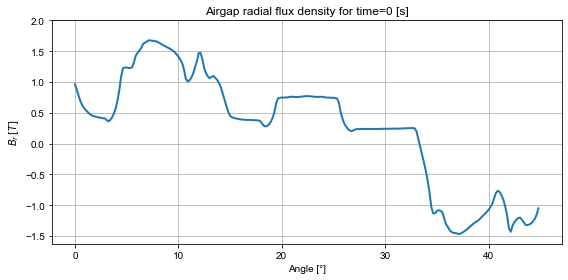

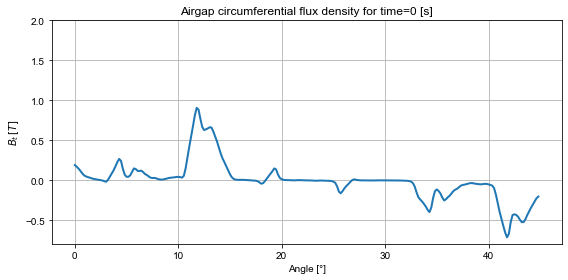

In [188]:
out_load.mag.B.plot_2D_Data("angle{°}")
out_load.mag.B.plot_2D_Data("angle[oneperiod]{°}",y_max=2)
out_load.mag.B.plot_2D_Data("angle[smallestperiod]{°}",y_max=2)

### Temporal Distribution

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

[0.        0.0003125 0.000625  0.0009375 0.00125   0.0015625 0.001875
 0.0021875 0.0025    0.0028125 0.003125  0.0034375 0.00375   0.0040625
 0.004375  0.0046875]
16
0.0046875


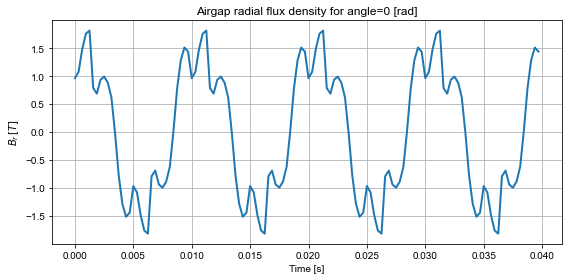

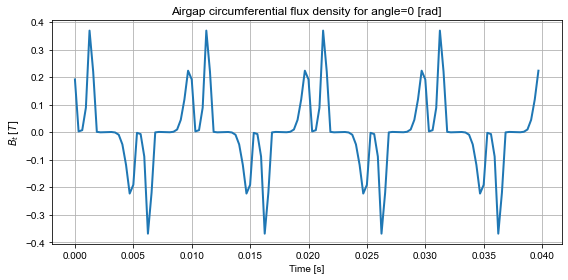

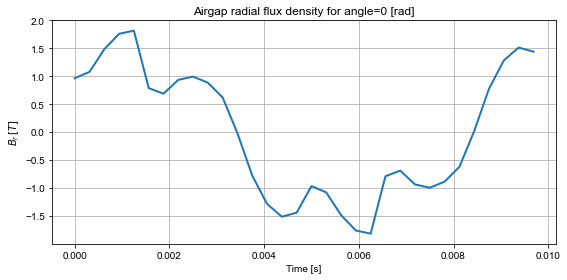

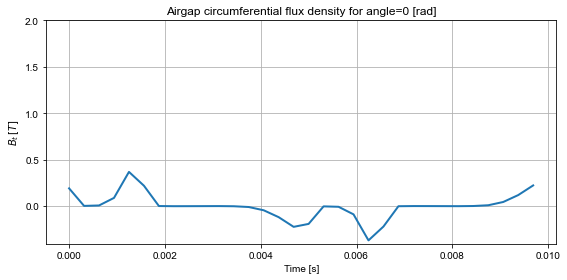

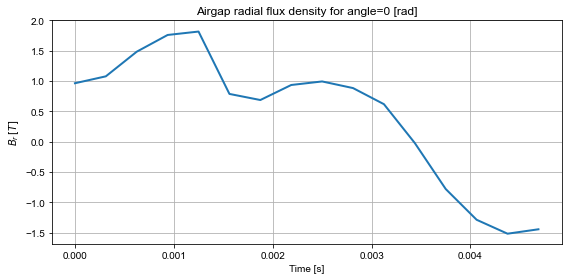

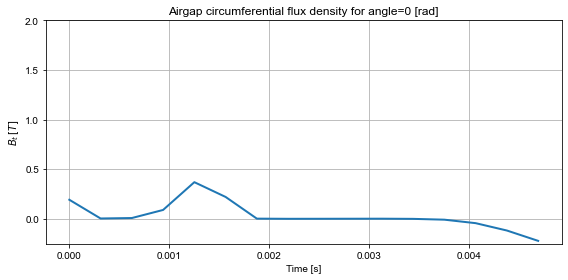

In [189]:
out_load.mag.B.plot_2D_Data("time")
out_load.mag.B.plot_2D_Data("time[oneperiod]",y_max=2)
out_load.mag.B.plot_2D_Data("time[smallestperiod]",y_max=2)
a=out_load.mag.B.get_xyz_along('time[smallestperiod]')
print(a['time'])
print(len(a['time']))
print(a['time'][-1])

## 주파수도메인 

### Time to freq  of B

[[0.9653518  0.87288096 0.78032498 ... 1.22326685 1.15770675 1.05064382]
 [1.07906003 1.07772024 1.08450222 ... 1.08045471 1.08431862 1.07755822]
 [1.48505486 1.47640519 1.48274252 ... 1.4864167  1.49947832 1.48596036]
 ...
 [1.28477193 1.27584942 1.26624071 ... 1.31781702 1.31386415 1.28757567]
 [1.51416037 1.52241156 1.49833509 ... 1.54171591 1.54049699 1.49846075]
 [1.44152256 1.42010593 1.3584723  ... 1.55804036 1.53476238 1.46089434]]


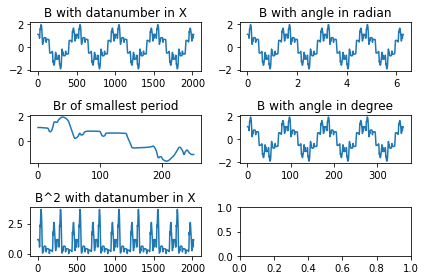

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


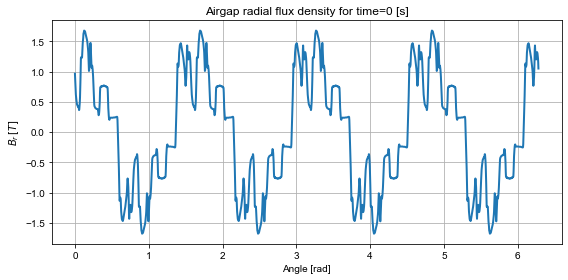

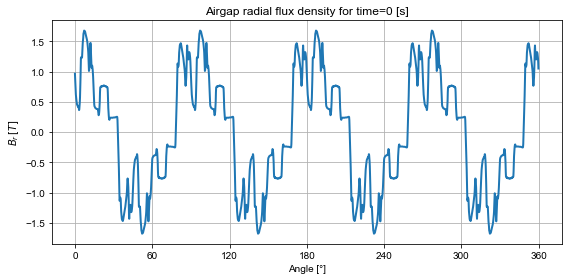

In [190]:
import matplotlib.pyplot as plt
arg_list = ["time", "angle"]
result = out_load.mag.B.get_rphiz_along(*arg_list)
B_r = result["radial"]
time = result["time"]
angle = result["angle"]
deg=angle*180/np.pi

arg_list_small= ["time[smallestperiod]", "angle[smallestperiod]"]
result_small = out_load.mag.B.get_rphiz_along(*arg_list_small)
B_r_small = result_small["radial"]
time_small = result_small["time"]
angle_small = result_small["angle"]
deg_small=angle_small*180/np.pi


Xangle, Xtime = meshgrid(angle, time)
# # Check time_to_freq reversibility
B_rad_freq = out_load.mag.B.components["radial"].time_to_freq()
# print(B_rad_freq)
result_frq = B_rad_freq.get_along(*arg_list)
# print(result_frq)
B_value_rad_freq = result_frq["B_r"]
print(B_value_rad_freq)

fig,ax=plt.subplots(3,2)
ax[0,0].plot(B_value_rad_freq[1])
ax[0, 0].set_title("B with datanumber in X")
ax[2,0].plot(B_value_rad_freq[1]**2)
ax[2,0].set_title("B^2 with datanumber in X")


ax[1,0].plot(B_r_small[1])
ax[1, 0].set_title("Br of smallest period")

ax[0,1].plot(angle,B_value_rad_freq[1])
ax[0, 1].set_title("B with angle in radian")

ax[1,1].plot(deg,B_value_rad_freq[1])
ax[1, 1].set_title("B with angle in degree")

fig.tight_layout()
plt.show()
# plt.plot(angle,B_value_rad_freq[1])
out_load.mag.B.components["radial"].plot_2D_Data('angle')
out_load.mag.B.components["radial"].plot_2D_Data('angle{°}')

### Time to freq of Force Density

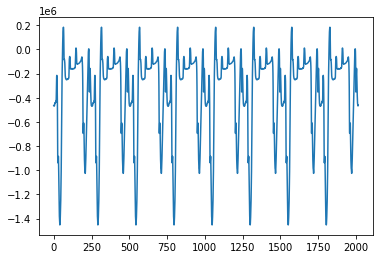

In [316]:
arg_list = ["time", "angle"]
result = AGSF_load.get_rphiz_along(*arg_list)
Prad = result["radial"]
time = result["time"]
angle = result["angle"]


Xangle, Xtime = meshgrid(angle, time)
# Check time_to_freq reversibility
AGSF_rad_freq = AGSF_load.components["radial"].time_to_freq()
AGSF_tan_freq = AGSF_load.components["tangential"].time_to_freq()
result_frq = AGSF_rad_freq.get_along(*arg_list)
Prad_frq = result_frq["AGSF_r"]
plt.plot(Prad_frq[1])


## Load vs No Load

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

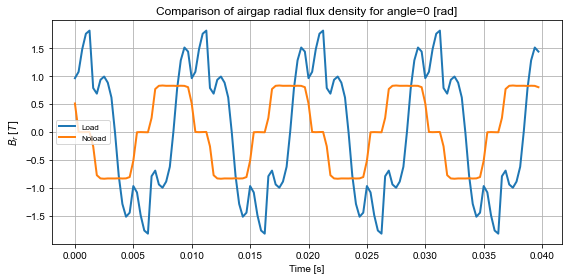

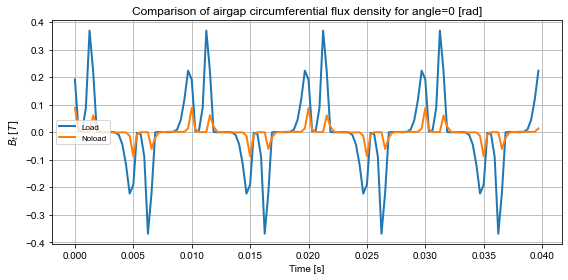

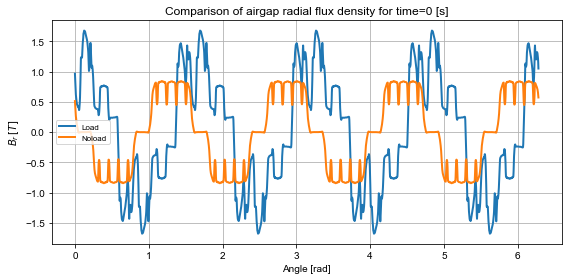

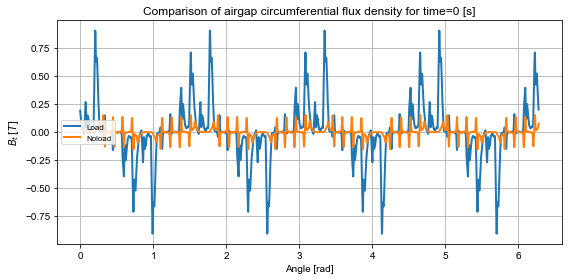

In [192]:
#---------------------------------------------------------------
# compare load and noload
out_load.mag.B.plot_2D_Data(
    "time", component_list=["radial"], data_list=[out_noload.mag.B], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
out_load.mag.B.plot_2D_Data(
    "time", component_list=["tangential"], data_list=[out_noload.mag.B], legend_list=["Load", "Noload"]
)


#---------------------------------------------------------------
# compare load and noload
out_load.mag.B.plot_2D_Data(
    "angle", component_list=["radial"], data_list=[out_noload.mag.B], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
out_load.mag.B.plot_2D_Data(
    "angle", component_list=["tangential"], data_list=[out_noload.mag.B], legend_list=["Load", "Noload"]
)

## FFT of B

#### 1D FFT

In [193]:

# Check time-space reconstruction
# arg_list = ["time", "angle"]
arg_list = ["freqs", "wavenumber"]
# result = out_load.mag.B.get_rphiz_along(*arg_list)
result_freq = out_load.mag.B.get_rphiz_along(*arg_list)

B_r = result["radial"]
time = result["time"]
angle = result["angle"]
deg=angle*180/np.pi

B_r_freq = result_freq["radial"]
freqs_B_r = result_freq["freqs"]
wavenumber_B_r = result_freq["wavenumber"]
Nf = len(freqs_B_r)
Nr = len(wavenumber_B_r)

print('Number of freqs_B_r:',Nf)
print('Temporal Frequency freq_in_mech=',freqs_B_r)
print('Number of wavenumber:',Nr)
print('Wavenumber r=:',wavenumber_B_r) # number of Wavenumber should be half of spatial data  from Nyquist Theorem 

Number of freqs_B_r: 17
Temporal Frequency freq_in_mech= [   0.  100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100.
 1200. 1300. 1400. 1500. 1600.]
Number of wavenumber: 504
Wavenumber r=: [-1008. -1004. -1000.  -996.  -992.  -988.  -984.  -980.  -976.  -972.
  -968.  -964.  -960.  -956.  -952.  -948.  -944.  -940.  -936.  -932.
  -928.  -924.  -920.  -916.  -912.  -908.  -904.  -900.  -896.  -892.
  -888.  -884.  -880.  -876.  -872.  -868.  -864.  -860.  -856.  -852.
  -848.  -844.  -840.  -836.  -832.  -828.  -824.  -820.  -816.  -812.
  -808.  -804.  -800.  -796.  -792.  -788.  -784.  -780.  -776.  -772.
  -768.  -764.  -760.  -756.  -752.  -748.  -744.  -740.  -736.  -732.
  -728.  -724.  -720.  -716.  -712.  -708.  -704.  -700.  -696.  -692.
  -688.  -684.  -680.  -676.  -672.  -668.  -664.  -660.  -656.  -652.
  -648.  -644.  -640.  -636.  -632.  -628.  -624.  -620.  -616.  -612.
  -608.  -604.  -600.  -596.  -592.  -588.  -584.  -580.  -576.  -572.
  -568.  -564.  

1)Fundemental Electrical frequency, Electrical temporal frequency : freq of f0= 100.0 Hz
**** The Frequency of Flux density change in "single" mesh ****
**** No spatial information <-> Deal later the effect of Rotor position(rotation) )**** 
Electrical temporal order : f0
Mechanical temporal order : H


C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Rotating frequency 25.0 Hz
So that (pole/2)*Elec angle=Mech angle, Temporal Freq is reciprocal : f0=4H
**** This is due to synchronism of (spatial-temporal) synchronous motor nature ****


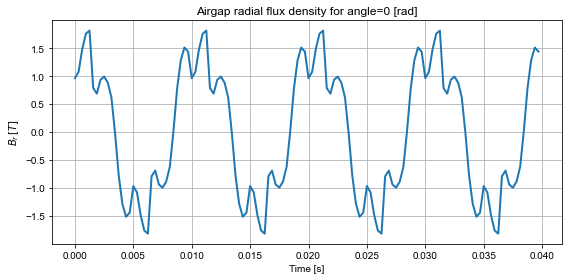

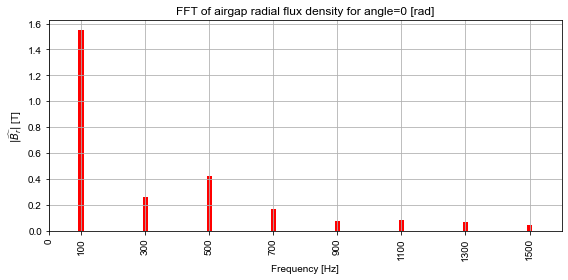

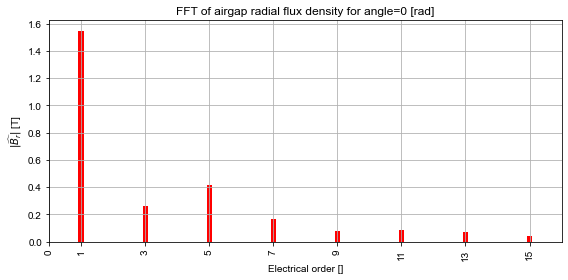

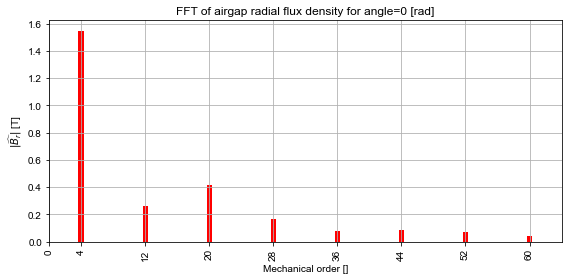

In [194]:
rpm=1500
poles=8
fre_e=(rpm/60.)*poles/2

print('1)Fundemental Electrical frequency, Electrical temporal frequency : freq of f0=',fre_e,'Hz')
print('**** The Frequency of Flux density change in "single" mesh ****')
print('**** No spatial information <-> Deal later the effect of Rotor position(rotation) )**** ')

out_load.mag.B.plot_2D_Data("time", component_list=["radial"])
out_load.mag.B.plot_2D_Data("freqs=[0,2e3]", component_list=["radial"], **dict_2D)
print('Electrical temporal order : f0')
out_load.mag.B.plot_2D_Data("freqs->elec_order=[0,50]", component_list=["radial"], **dict_2D)
print('Mechanical temporal order : H')
out_load.mag.B.plot_2D_Data("freqs->mech_order=[-200,200]", component_list=["radial"], **dict_2D)




print('Rotating frequency', 1500/60, 'Hz')

print("So that (pole/2)*Elec angle=Mech angle, Temporal Freq is reciprocal : f0=4H")
print("**** This is due to synchronism of (spatial-temporal) synchronous motor nature ****")

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


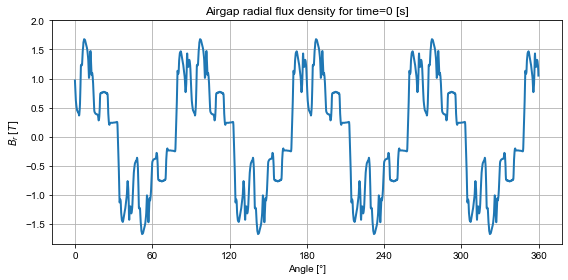

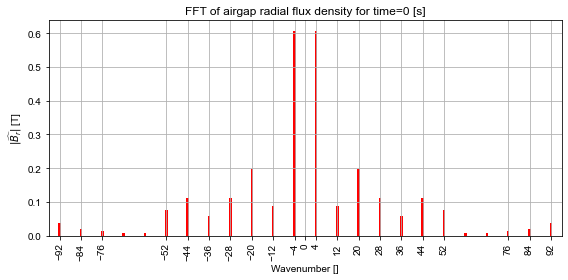

In [170]:
# print('spatial order : r')
out_load.mag.B.plot_2D_Data("angle{°}", component_list=["radial"],y_max=2)
out_load.mag.B.plot_2D_Data("wavenumber=[-96,96]", component_list=["radial"], **dict_2D)


#### 2D FFT(3D view)

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C9CA35910>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C9CA35910> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C96773160>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.col

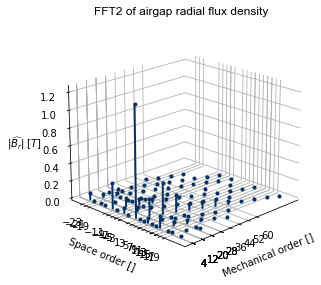

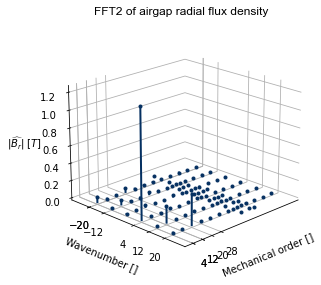

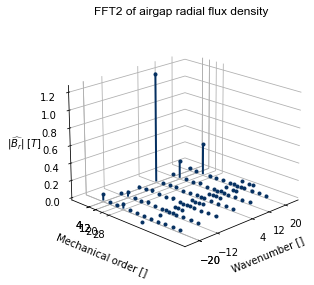

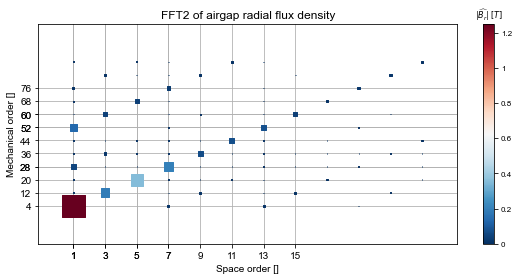

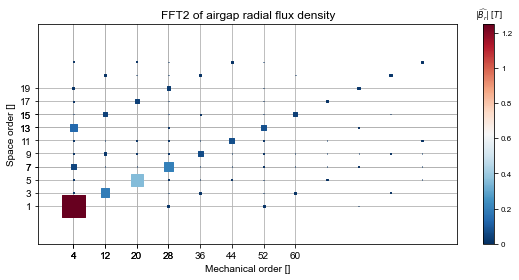

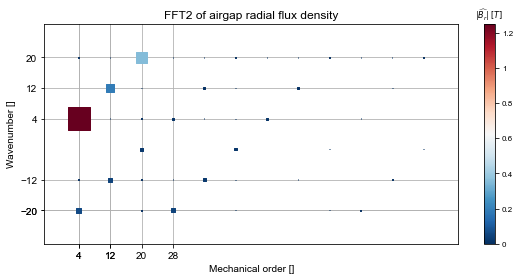

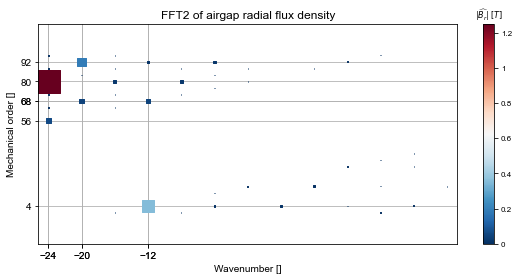

In [171]:
out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-24,24]",
    N_stem=100,    
    component_list=["radial"],
    is_2D_view=False,
#     **dict_3D

)
out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=False,
#     **dict_3D

)

out_load.mag.B.plot_3D_Data(
    "wavenumber=[-24,24]",
    "freqs->mech_order=[0,96]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=False,
#     **dict_3D

)

out_load.mag.B.plot_3D_Data(
    "wavenumber->space_order=[0,24]",
    "freqs->mech_order=[0,96]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)
out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[0,24]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)

out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)

** Do not change freq - wavenumber
out_load.mag.B.plot_3D_Data(
    "wavenumber=[-24,24]",
    "freqs->mech_order=[0,96]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)

# Plot & Data Check Electromagnetic Force Density[P]


Force 추상 클래스를 사용하면 힘을 계산하는 다양한 방법을 정의할 수 있습니다.

ForceMT 클래스는 Force 클래스에서 상속됩니다. ForceMT는 Maxwell 응력 텐서 \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]를 기반으로 하는 공극 표면력을 계산합니다.

여기서 우리는 힘 계산 없이 자기 시뮬레이션의 결과를 얻습니다. Force 모듈은 초기화되고 단독으로 실행됩니다.
시뮬레이션이 완료되면 결과가 출력의 force 부분(예: _myResults.force_ )에 저장되고 다른 플롯을 호출할 수 있습니다. 이 개체에는 다음이 포함됩니다.
- *시간*: 시간 축
- *각도*: 각도 위치 축
- *AGSF*: 에어갭 표면력(방사형 및 접선 성분)
    
**출력** 개체는 결과를 쉽게 시각화하기 위해 다른 플롯을 포함합니다. 

## Data check(Load vs No load)


C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

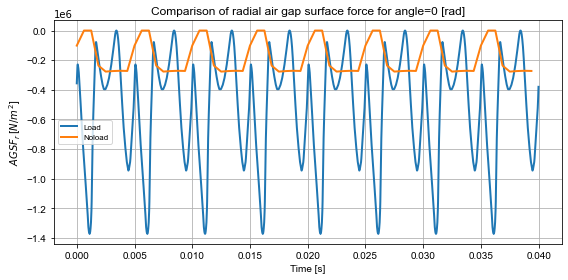

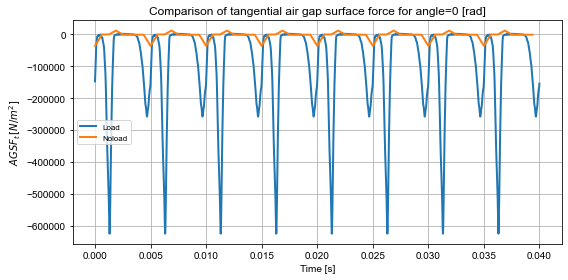

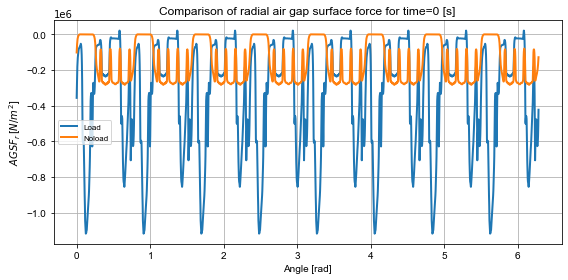

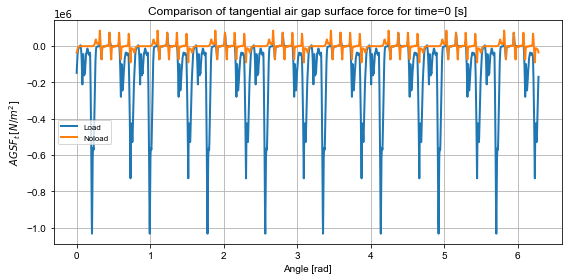

In [172]:
# AGSF_load.plot_2D_Data_Animated("time",'angle',save_path="D:/AGSF_load.gif",)
#AGSF_rad_freq.plot_2D_Data("time")
# AGSF_noload.plot_2D_Data('time')

#---------------------------------------------------------------
# compare load and noload
AGSF_load.plot_2D_Data(
    "time", component_list=["radial"], data_list=[AGSF_noload], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
AGSF_load.plot_2D_Data(
    "time", component_list=["tangential"], data_list=[AGSF_noload], legend_list=["Load", "Noload"]
)


#---------------------------------------------------------------
# compare load and noload
AGSF_load.plot_2D_Data(
    "angle", component_list=["radial"], data_list=[AGSF_noload], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
AGSF_load.plot_2D_Data(
    "angle", component_list=["tangential"], data_list=[AGSF_noload], legend_list=["Load", "Noload"]
)
# AGSF_load.plot_2D_Data('time',component_list=["radial"])
# AGSF_noload.plot_2D_Data('time',component_list=["radial"])
# AGSF_load.plot_2D_Data('time',component_list=["tangential"])
# AGSF_noload.plot_2D_Data('time',component_list=["tangential"])


# AGSF_load.plot_2D_Data('angle',component_list=["radial"])
# AGSF_noload.plot_2D_Data('angle',component_list=["radial"])
# AGSF_load.plot_2D_Data('angle',component_list=["tangential"])
# AGSF_noload.plot_2D_Data('angle',component_list=["tangential"])

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C875C0FD0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C875C0FD0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


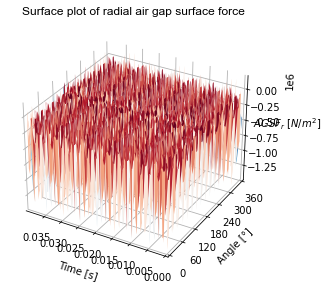

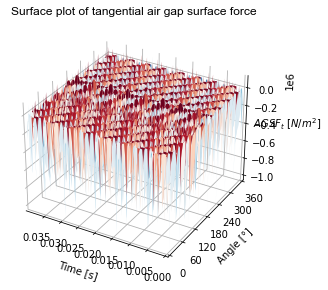

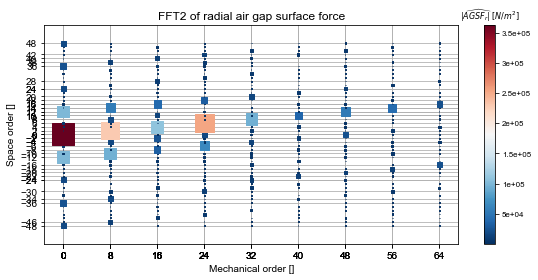

In [197]:
AGSF_load.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)
#------------------------------------------------------

## FFT of P

### 1D FFT

In [173]:
# Check time-space reconstruction
arg_list = ["freqs", "wavenumber"]
result_freq = AGSF_load.get_rphiz_along(*arg_list)
Prad_wr = result_freq["radial"]
freqs_AGSF = result_freq["freqs"]
wavenumber = result_freq["wavenumber"]
Nf = len(freqs_AGSF)
Nr = len(wavenumber)
print('Number of freqs_AGSF:',Nf)
print('Temporal Frequency freq_in_mech=',freqs_AGSF)
print('Number of wavenumber:',Nr)
print('Wavenumber r=:',wavenumber)



Number of freqs_AGSF: 257
Temporal Frequency freq_in_mech= [    0.   200.   400.   600.   800.  1000.  1200.  1400.  1600.  1800.
  2000.  2200.  2400.  2600.  2800.  3000.  3200.  3400.  3600.  3800.
  4000.  4200.  4400.  4600.  4800.  5000.  5200.  5400.  5600.  5800.
  6000.  6200.  6400.  6600.  6800.  7000.  7200.  7400.  7600.  7800.
  8000.  8200.  8400.  8600.  8800.  9000.  9200.  9400.  9600.  9800.
 10000. 10200. 10400. 10600. 10800. 11000. 11200. 11400. 11600. 11800.
 12000. 12200. 12400. 12600. 12800. 13000. 13200. 13400. 13600. 13800.
 14000. 14200. 14400. 14600. 14800. 15000. 15200. 15400. 15600. 15800.
 16000. 16200. 16400. 16600. 16800. 17000. 17200. 17400. 17600. 17800.
 18000. 18200. 18400. 18600. 18800. 19000. 19200. 19400. 19600. 19800.
 20000. 20200. 20400. 20600. 20800. 21000. 21200. 21400. 21600. 21800.
 22000. 22200. 22400. 22600. 22800. 23000. 23200. 23400. 23600. 23800.
 24000. 24200. 24400. 24600. 24800. 25000. 25200. 25400. 25600. 25800.
 26000. 26200. 264

1)Fundemental Electrical frequency, Electrical temporal frequency : freq of f0= 100.0 Hz
**** The Frequency of Flux density change in "single" mesh ****
**** No spatial information <-> Deal later the effect of Rotor position(rotation) )**** 


C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Electrical temporal order : f0
Mechanical temporal order : H
Rotating frequency 25.0 Hz
So that (pole/2)*Elec angle=Mech angle, Temporal Freq is reciprocal : f0=4H
**** This is due to synchronism of (spatial-temporal) synchronous motor nature ****


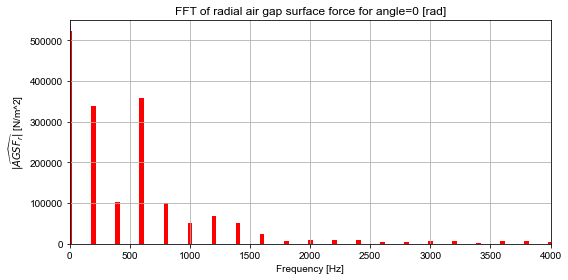

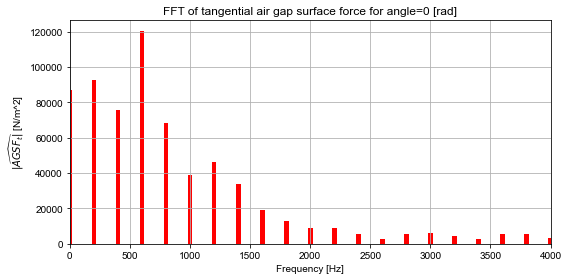

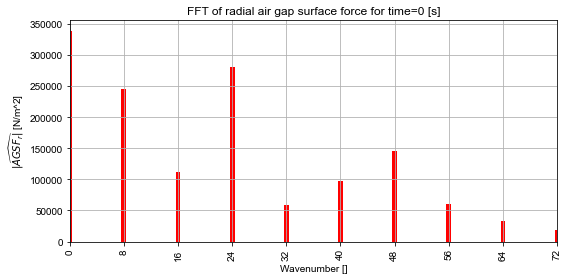

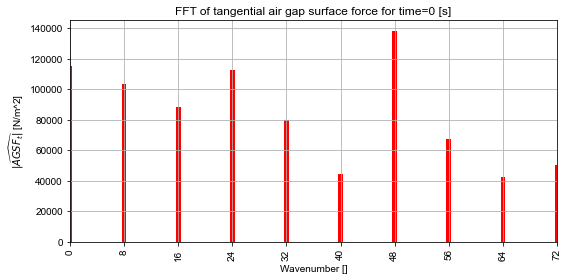

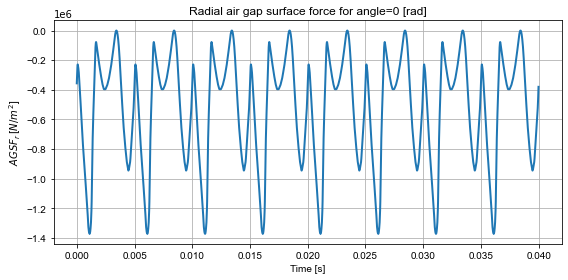

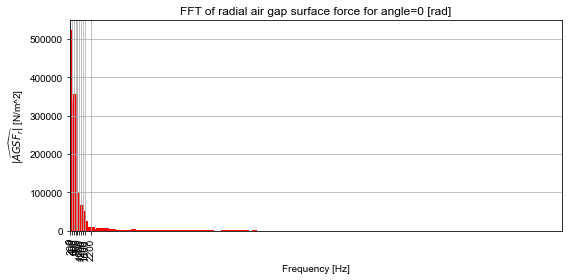

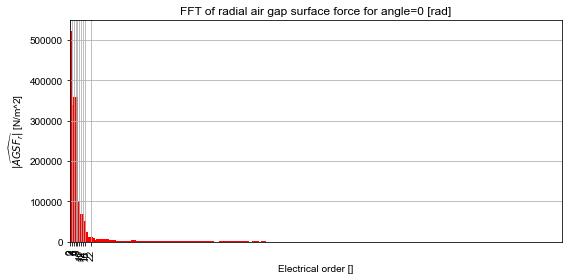

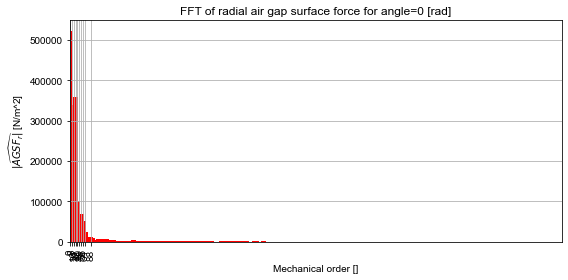

In [175]:
rpm=1500
poles=8
fre_e=(rpm/60.)*poles/2

print('1)Fundemental Electrical frequency, Electrical temporal frequency : freq of f0=',fre_e,'Hz')
print('**** The Frequency of Flux density change in "single" mesh ****')
print('**** No spatial information <-> Deal later the effect of Rotor position(rotation) )**** ')

AGSF_load.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False, **dict_2D)
AGSF_load.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

AGSF_load.plot_2D_Data("time", component_list=["radial"])
AGSF_load.plot_2D_Data("freqs", component_list=["radial"], **dict_2D)
print('Electrical temporal order : f0')
AGSF_load.plot_2D_Data("freqs->elec_order", component_list=["radial"], **dict_2D)
print('Mechanical temporal order : H')
AGSF_load.plot_2D_Data("freqs->mech_order", component_list=["radial"], **dict_2D)




print('Rotating frequency', 1500/60, 'Hz')

print("So that (pole/2)*Elec angle=Mech angle, Temporal Freq is reciprocal : f0=4H")
print("**** This is due to synchronism of (spatial-temporal) synchronous motor nature ****")


C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


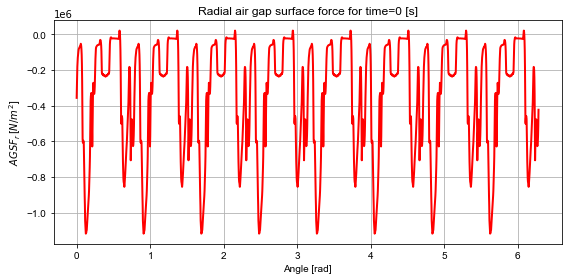

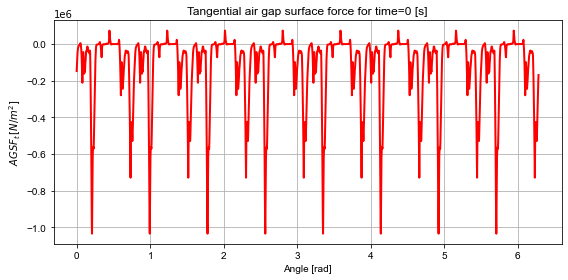

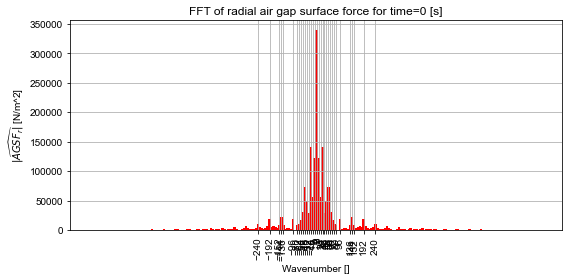

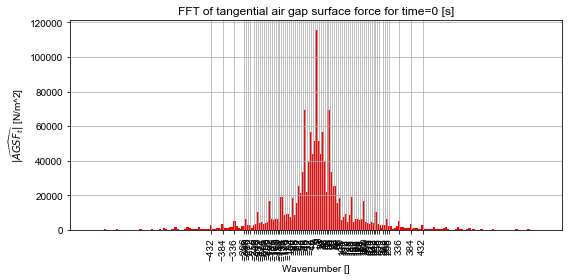

In [176]:
AGSF_load.plot_2D_Data("angle", component_list=["radial"], **dict_2D)
AGSF_load.plot_2D_Data("angle", component_list=["tangential"], **dict_2D)
AGSF_load.plot_2D_Data("wavenumber", component_list=["radial"], **dict_2D)
AGSF_load.plot_2D_Data("wavenumber", component_list=["tangential"], **dict_2D)


### 2D FFT

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C97D3CCD0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C97D3CCD0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C86E5EEE0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C86E5EEE0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C95748730>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C95748730> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C9CA35850>
DEBUG:matplotlib.colorb

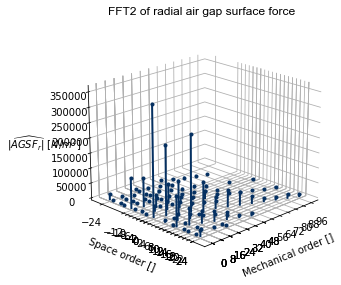

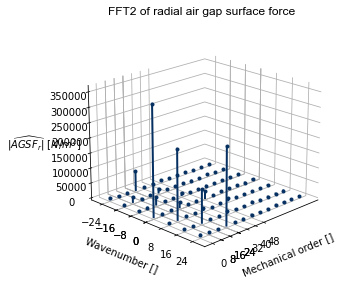

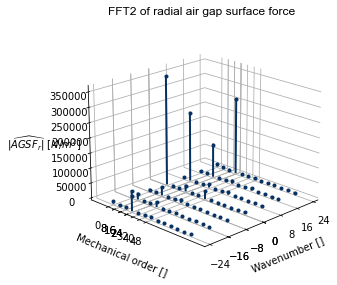

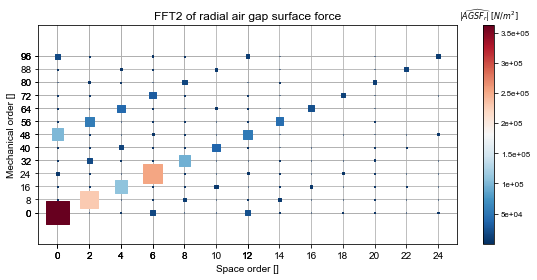

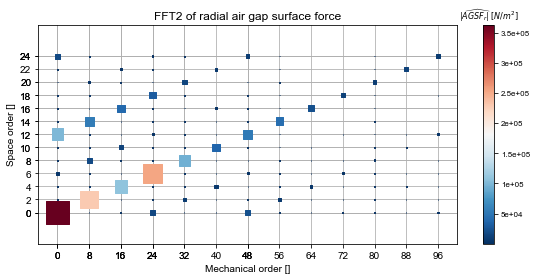

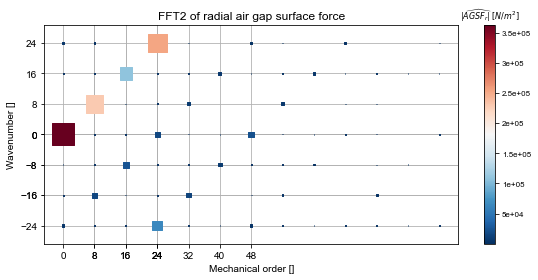

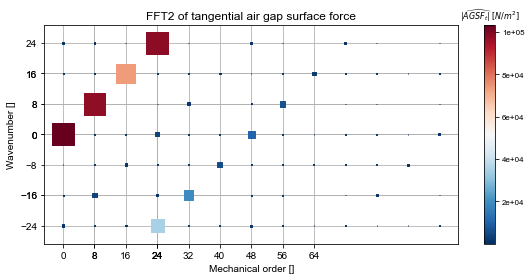

In [179]:
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-24,24]",
    N_stem=100,    
    component_list=["radial"],
    is_2D_view=False,
#     **dict_3D

)
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=False,
#     **dict_3D

)

AGSF_load.plot_3D_Data(
    "wavenumber=[-24,24]",
    "freqs->mech_order=[0,96]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=False,
#     **dict_3D

)

AGSF_load.plot_3D_Data(
    "wavenumber->space_order=[0,24]",
    "freqs->mech_order=[0,96]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[0,24]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)

AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D

)

AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D

)

# # Do not use
# AGSF_load.plot_3D_Data(
#     "wavenumber=[-24,24]",
#     "freqs->mech_order=[0,96]",
#     N_stem=100,
#     component_list=["radial"],
#     is_2D_view=True,
# #     **dict_3D

# )


In [118]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Functions.Plot import dict_2D, dict_3D
import matplotlib.pyplot as plt

fname="D:/AGSF_rad_freq.gif"
AGSF_rad_freq.plot_2D_Data_Animated("time",'wavenumber',save_path=fname,)
  


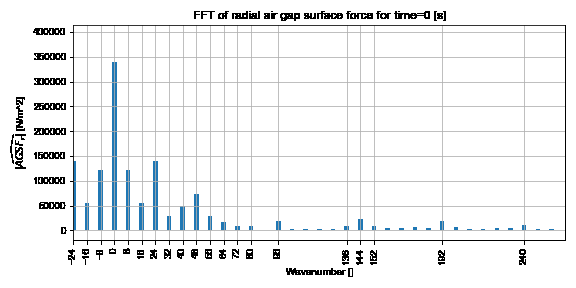

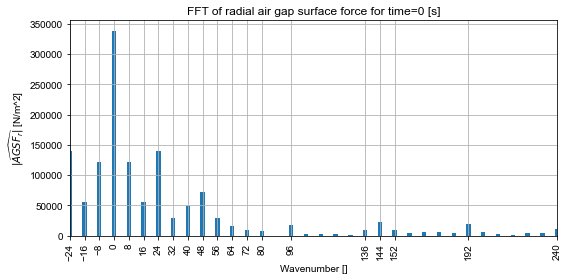

In [106]:
AGSF_load.plot_2D_Data('wavenumber=[-24,240]',component_list=["radial"])

def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif(fname)

다음 플롯은 시간과 각도에 따른 방사형 에어 갭 표면력을 표시합니다.

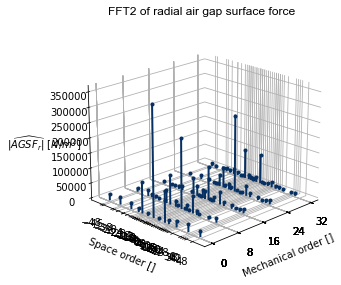

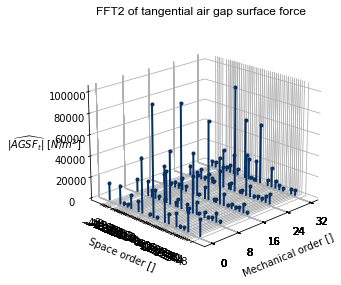

In [141]:
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,200]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    #component_list=["radial"],
    is_2D_view=False,
    **dict_3D

)
#------------------------------------------------------

 
이 튜토리얼과 관련된 노트북은 [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb)에서 볼 수 있습니다.

# Force vs Torque

C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C878D24C0>


34.84984778861651
13.131898012750828
47.98174580136734
85.39952606985247
1.7798336563947792


DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021C878D24C0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
C:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021CA0F8BDF0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021CA0F8BDF0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


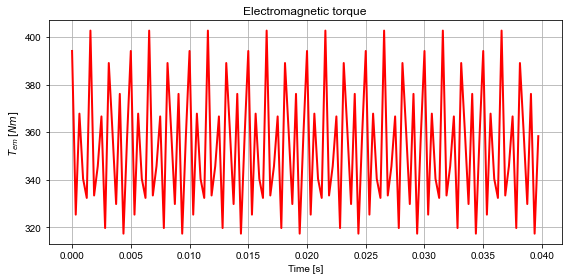

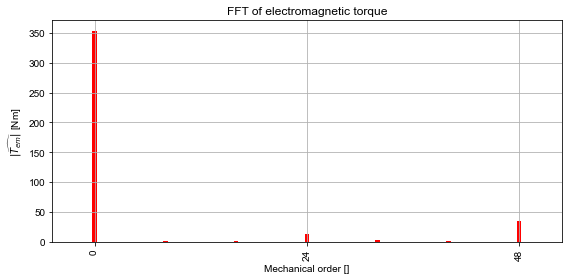

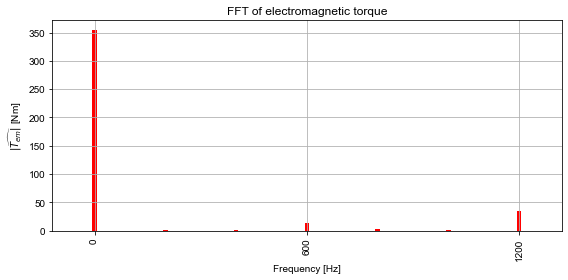

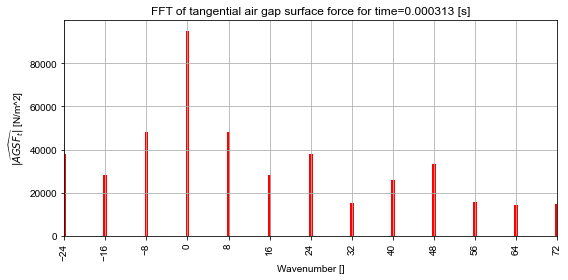

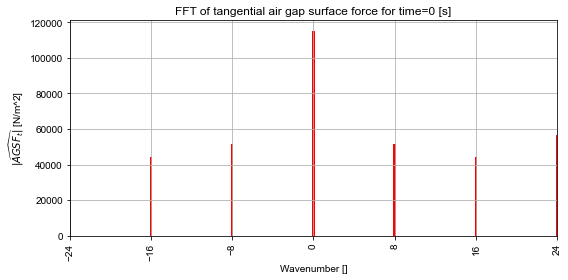

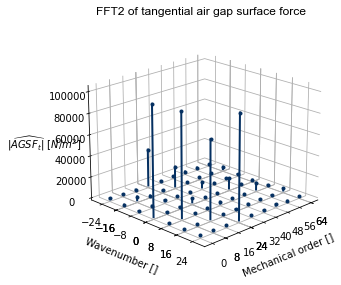

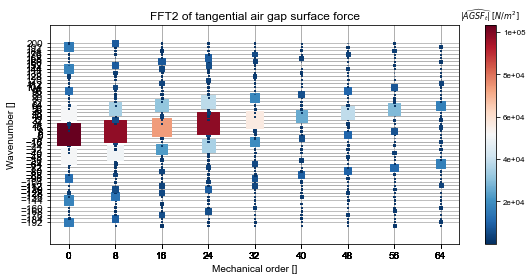

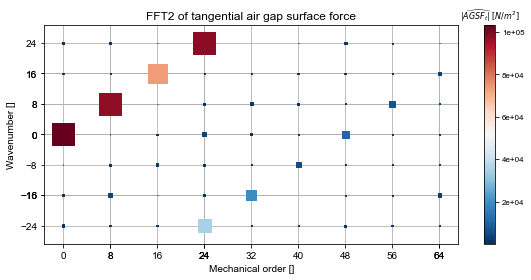

In [352]:
out_load.mag.Tem.plot_2D_Data("time", **dict_2D)
out_load.mag.Tem.time_to_freq()
# print(out_load.mag.Tem.values.ndim)
# print(out_load.mag.Tem)
out_load.mag.Tem_rip_norm
out_load.mag.Tem_rip_pp

result = out_load.mag.Tem.time_to_freq()
out_load.mag.Tem.plot_2D_Data("freqs->mech_order=[-48,96]", **dict_2D)

# print(result)
a=result.values
# np.absolute(a[0])
print(np.absolute(a[6]))
print(np.absolute(a[3]))

rip=np.absolute(a[3])+np.absolute(a[6])
print(rip)
print(out_load.mag.Tem_rip_pp)
print(out_load.mag.Tem_rip_pp/rip)
out_load.mag.Tem.plot_2D_Data("freqs", **dict_2D)


AGSF_load.plot_2D_Data("wavenumber=[-24,78]","time[1]",component_list=["tangential"], **dict_2D)
AGSF_load.plot_2D_Data("wavenumber=[-24,24]","time[0]",component_list=["tangential"], **dict_2D)
# # AGSF_in_freq_fname="D:/AGSF_freq.gif"
# # AGSF_rad_freq.plot_2D_Data_Animated("angle","freqs->mech_order",save_path=AGSF_in_freq_fname)
# AGSF_in_wave_fname="D:/AGSF_wavenumber.gif"
# AGSF_tan_freq.plot_2D_Data_Animated("time","wavenumber",save_path=AGSF_in_wave_fname)
# # show_gif(AGSF_in_freq_fname)
# show_gif(AGSF_in_wave_fname)
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=False,
#     **dict_3D

)



AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-200,200]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D

)

AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D

)


